# Setting up the baseline

In [45]:
# Install a compatible version of TensorFlow, e.g., 2.8 or higher
!pip install tensorflow==2.8.0

# Install the other required packages
!pip install mne>=0.17.1 PyRiemann>=0.2.5 scikit-learn>=0.20.1 matplotlib>=2.2.3

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [46]:
# Clone the repository (replace the URL with the correct one if needed)
!git clone https://github.com/vlawhern/arl-eegmodels.git

# Navigate to the cloned directory
%cd arl-eegmodels

Cloning into 'arl-eegmodels'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 112 (delta 1), reused 4 (delta 1), pack-reused 106 (from 1)
Receiving objects: 100% (112/112), 80.61 KiB | 2.07 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/kaggle/working/arl-eegmodels/arl-eegmodels


In [47]:
import os
import numpy as np
import scipy.signal as signal


In [48]:
import sys
sys.path.append('/content/arl-eegmodels')

# config

In [49]:
config = {
    "subjects": False
}

# Data Preprocessing

In [50]:
eeg = "/kaggle/input/ssvep-bci-benchmark-dataset/SSVEP_BCI_Dataset"

## Visualizing one subject

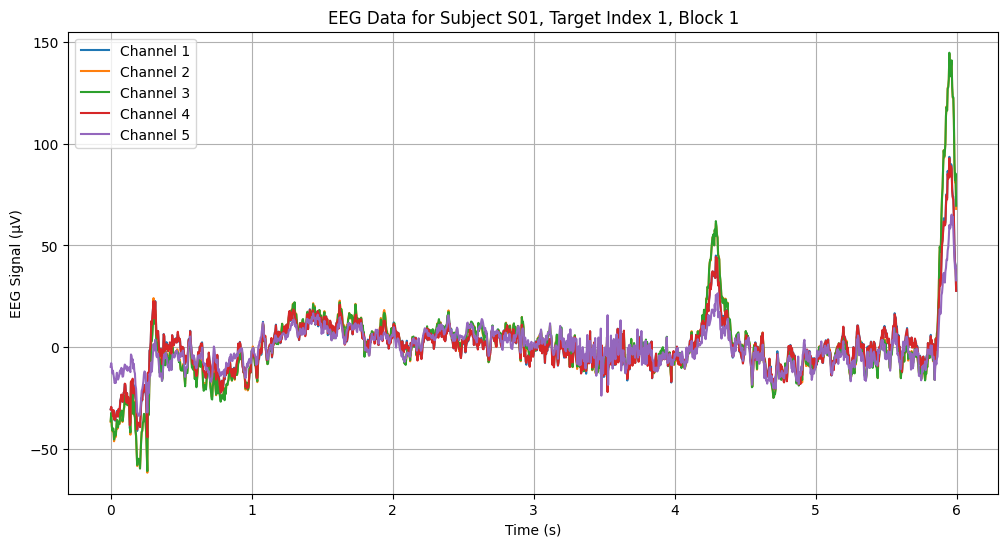

In [53]:
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

def load_and_visualize_subject_data(subject_id, base_path=eeg, target_index=0, block_index=0):
    """Loads and visualizes EEG data for a given subject from the specified directory."""
    file_path = os.path.join(base_path, 'Subject_Data', f'S{subject_id}.mat/S{subject_id}.mat')
    data = sio.loadmat(file_path)['data']  # Access the 'data' key in .mat file

    # Visualize EEG data
    plt.figure(figsize=(12, 6))
    
    # Select a few channels (e.g., first 5 electrodes)
    channels_to_plot = data[:5, :, target_index, block_index]  # Shape: [5, 1500]
    
    # Time vector based on sampling rate (250 Hz)
    time_vector = np.arange(channels_to_plot.shape[1]) / 250.0  # 250 samples/sec

    for channel in range(channels_to_plot.shape[0]):
        plt.plot(time_vector, channels_to_plot[channel, :], label=f'Channel {channel + 1}')

    plt.title(f'EEG Data for Subject S0{subject_id}, Target Index {target_index + 1}, Block {block_index + 1}')
    plt.xlabel('Time (s)')
    plt.ylabel('EEG Signal (µV)')
    plt.legend()
    plt.grid()
    plt.show()

    return data  # Shape: [64, 1500, 40, 6]

# Load and visualize data for subject 1
data = load_and_visualize_subject_data(1)

In **EEG (electroencephalography)**, different channels refer to the **individual electrode placements** on the scalp that measure electrical activity. **Each channel** captures brain signals from a specific location, allowing for the monitoring of neural activity across various regions of the brain. The combination of data from these channels helps to identify patterns related to cognitive processes, sensory experiences, or neurological conditions, facilitating a comprehensive understanding of brain function during tasks such as the **SSVEP (steady-state visual evoked potential)** experiment.

The dataset contains **64 channels**, which correspond to the electrode placements used to measure EEG signals from the scalp according to the international 10-20 system. Each channel captures electrical activity from a specific location on the head, allowing for detailed analysis of brain function.

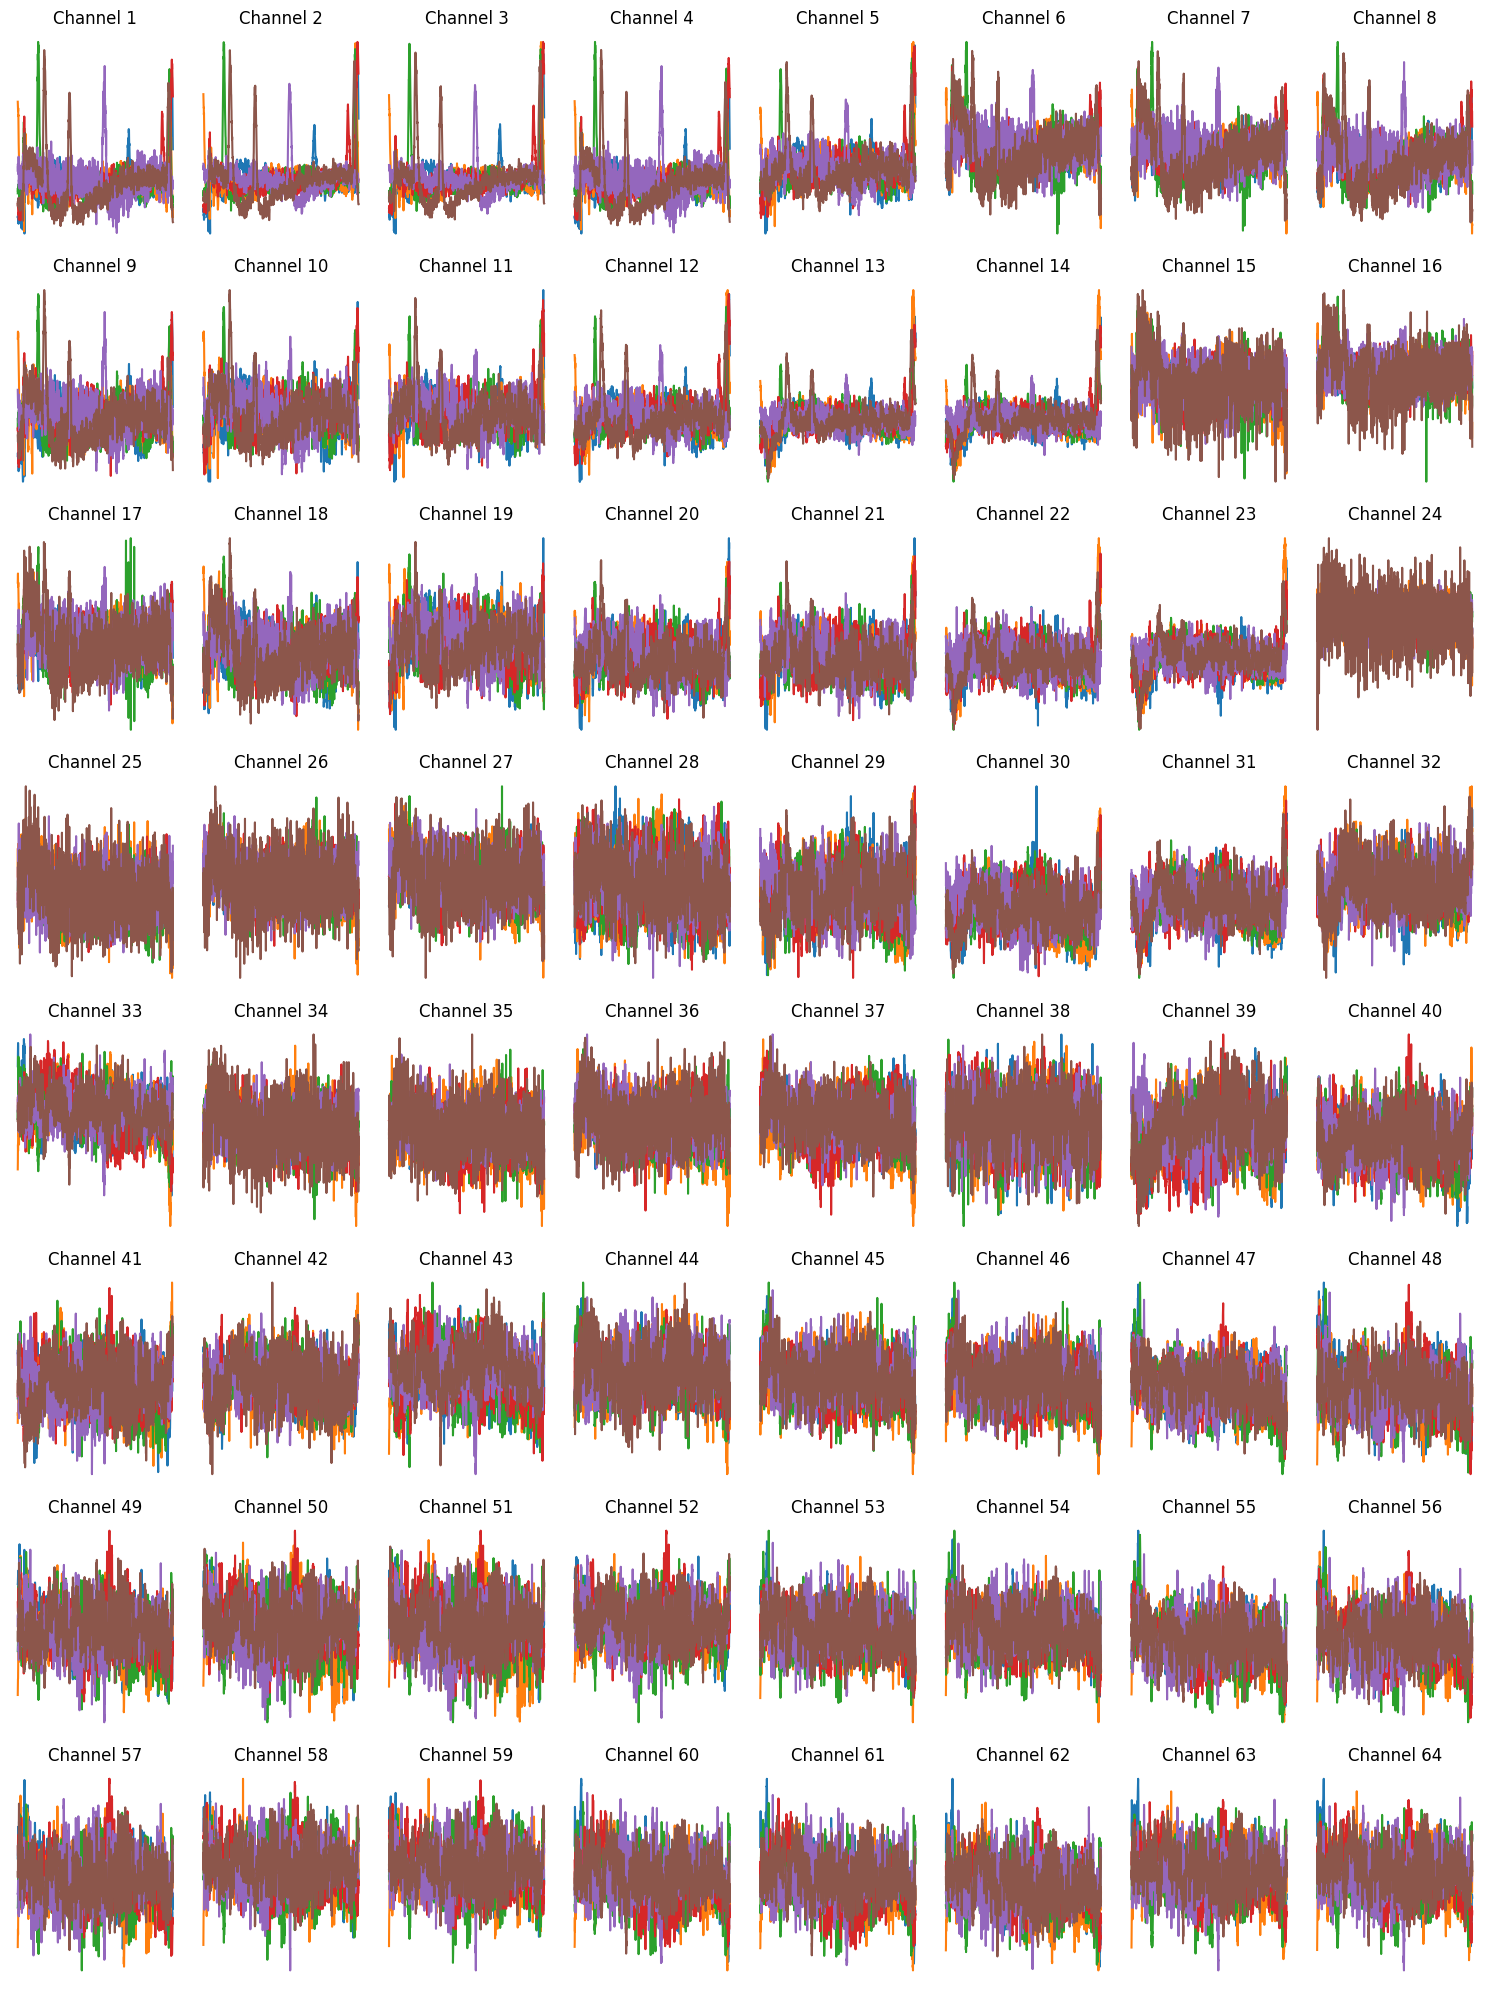

In [54]:
def load_and_visualize_subject_data(subject_id, base_path=eeg, trial_index=0):
    """Loads EEG data for a given subject and visualizes all 64 channels for a single trial."""
    # Load the data
    file_path = os.path.join(base_path, 'Subject_Data', f'S{subject_id}.mat/S{subject_id}.mat')
    data = sio.loadmat(file_path)['data']  # Shape: [64, 1500, 40, 6]

    # Visualize all 64 channels for the specified trial
    plt.figure(figsize=(15, 20))
    for channel in range(data.shape[0]):  # Iterate over all 64 channels
        plt.subplot(8, 8, channel + 1)  # Create a subplot for each channel
        plt.plot(data[channel, :, trial_index])  # Plot the data for the specified trial
        plt.title(f'Channel {channel + 1}')
        plt.axis('off')  # Hide axes for cleaner visualization

    plt.tight_layout()
    plt.show()

# Visualize EEG data for subject 1, trial index 0
load_and_visualize_subject_data(subject_id=1, trial_index=0)


The graphs represent the raw EEG signals recorded from each of the 64 channels (electrodes) placed on the scalp of a subject during an SSVEP (Steady-State Visual Evoked Potential) BCI experiment. Each plot shows the time-series data collected from one channel over the duration of a trial, capturing voltage fluctuations caused by neural activity in response to visual stimuli flickering at different frequencies. The EEG patterns vary between channels, as each records activity from different brain regions. Observing these patterns can reveal how the brain responds to specific visual cues.

## Preprocessing steps

### Bandpass filtering

Use a bandpass filter to isolate the SSVEP frequencies (e.g., 8-15 Hz) by filtering out noise and unrelated frequencies.

In [ ]:
def bandpass_filter(data, low_freq=8, high_freq=15, fs=250):
    nyquist = 0.5 * fs
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = signal.butter(4, [low, high], btype="band")
    return signal.lfilter(b, a, data, axis=1)


In [ ]:
def normalize_data(data):
    return (data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True)


Normalize each channel's data to improve model performance.

### Preprocessing one subject

In [ ]:
# Load EEG Data
def load_subject_data(subject_id, base_path):
    file_path = os.path.join(base_path, 'Subject_Data', f'S{subject_id}.mat/S{subject_id}.mat')
    data = sio.loadmat(file_path)['data']  # Shape: [64, 1500, 40, 6]
    return data

# Preprocess EEG Data
def preprocess_data(data, low_freq=8, high_freq=15, fs=250, samples=128):
    # Bandpass filter
    nyquist = 0.5 * fs
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = signal.butter(4, [low, high], btype="band")
    data_filtered = signal.lfilter(b, a, data, axis=1)
    
    # Downsample
    data_resampled = signal.resample(data_filtered, samples, axis=1)
    
    # Normalize
    data_normalized = (data_resampled - np.mean(data_resampled, axis=1, keepdims=True)) / np.std(data_resampled, axis=1, keepdims=True)
    
    # Reshape for EEGNet: (trials, channels, samples, 1)
    num_trials = data_normalized.shape[2] * data_normalized.shape[3]
    data_reshaped = data_normalized.reshape((64, samples, num_trials, 1)).transpose(2, 0, 1, 3)
    
    return data_reshaped

# Load and preprocess data for a specific subject
subject_id = 1
data = load_subject_data(subject_id, eeg)
preprocessed_data = preprocess_data(data)
print("Preprocessed data shape:", preprocessed_data.shape)  # Should match EEGNet input requirements


### Preprocessing for all the subjects

In [ ]:
# Load and preprocess data for all subjects
def load_and_preprocess_all_subjects(num_subjects, base_path):
    all_data = []
    all_labels = []

    for subject_id in range(1, num_subjects + 1):
        data = load_subject_data(subject_id, base_path)
        preprocessed_data = preprocess_data(data)
        
        # Generate labels for each subject's data
        num_trials = data.shape[2]
        num_classes = data.shape[3]
        labels = np.array([class_idx for class_idx in range(num_classes) for _ in range(num_trials)])
        
        all_data.append(preprocessed_data)
        all_labels.append(labels)

    # Concatenate data and labels from all subjects
    all_data = np.concatenate(all_data, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # One-hot encode the labels
    all_labels_one_hot = to_categorical(all_labels, num_classes)

    return all_data, all_labels_one_hot

### labels

In [ ]:
import numpy as np

def create_labels(data):
    """Creates labels from the target index."""
    num_trials = data.shape[2]  # 40 trials
    num_blocks = data.shape[3]   # 6 blocks
    labels = []

    for block in range(num_blocks):
        for trial in range(num_trials):
            labels.append(trial)  # Append the target index as the label

    return np.array(labels)

# Assume data has been loaded and preprocessed
labels = create_labels(data)
print("Labels shape:", labels.shape)  # Should be (240,)


# Model architecture

## ARCHITECTURE FOR ONE SUBJECT

In [ ]:
# from EEGModels import EEGNet, ShallowConvNet, DeepConvNet

# # Creating an EEGNet model : params include:
# model = EEGNet(nb_classes=40, Chans=64, Samples=128, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, dropoutType='Dropout')

# # Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.summary()

In [ ]:
from EEGModels import EEGNet, ShallowConvNet, DeepConvNet
if config['subjects'] == True:
    # Load data for all subjects
    num_subjects = 35  # Adjust based on the actual number of subjects
    X, y = load_and_preprocess_all_subjects(num_subjects, eeg)
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and compile the EEGNet model
    model = EEGNet(nb_classes=y.shape[1], Chans=64, Samples=128, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, dropoutType='Dropout')
else:
    # Creating an EEGNet model : params include:
    model = EEGNet(nb_classes=40, Chans=64, Samples=128, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, dropoutType='Dropout')

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

## Architecture for all subjects

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

if config['subjects'] == True:
    # Load data for all subjects
    num_subjects = 35  # Adjust based on the actual number of subjects
    preprocessed_data, labels_one_hot = load_and_preprocess_all_subjects(num_subjects, eeg)
else:
    # Assuming labels is an array of your target labels, ensure this has the correct shape
    labels = create_labels(data)  # Shape: (240,)
    # Set the number of unique classes
    num_classes = 40  # Update this based on your actual number of classes
    # One-hot encode the labels
    labels_one_hot = to_categorical(labels, num_classes)
    # Load and preprocess data for a specific subject
    subject_id = 1
    data = load_subject_data(subject_id, eeg)
    preprocessed_data = preprocess_data(data)


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(preprocessed_data, labels_one_hot, test_size=0.2, random_state=42)

In [ ]:
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils import to_categorical

# # Assuming labels is an array of your target labels, ensure this has the correct shape
# labels = create_labels(data)  # Shape: (240,)

# # Set the number of unique classes
# num_classes = 40  # Update this based on your actual number of classes

# # One-hot encode the labels
# labels_one_hot = to_categorical(labels, num_classes)

# # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(preprocessed_data, labels_one_hot, test_size=0.2, random_state=42)

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=2)

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val, batch_size=32, verbose=2)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
